<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Long Short Term Memory (cnn-cnn-cnn-cnn-cnn-cnn-cnn-lstm)

###Load Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.layers import Dropout

###Define Functions to Facilitate Metrics Evaluation

In [21]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [22]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/multivariate-time-series-prediction-of-crude-palm-oil-price-data-science-approach/main/cleaned_data/preprocessed.csv'
df = read_csv(path, index_col=0)
df.head()

,Date,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
0,2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
1,2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2,2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
3,2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
4,2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


In [23]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d')
del df['Date']

In [24]:
df.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Plot the Target Variable

Text(0.5, 0, 'Date')

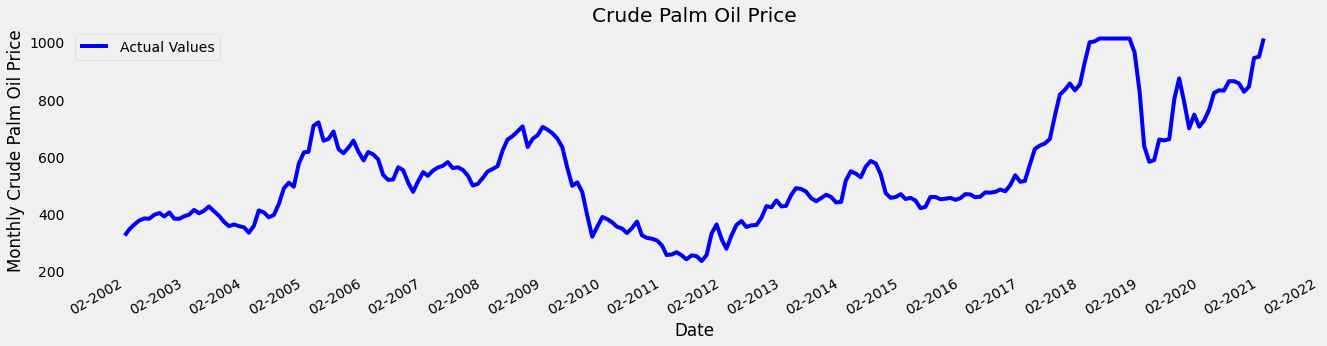

In [25]:
plt.figure(figsize=(20,5))
plt.grid()
plt.plot(df.index, df['cpo_pri'], color = 'blue',  label = 'Test')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.gcf().autofmt_xdate() # Rotation
plt.legend(['Actual Values', 'Crude Palm Oil Price 2002-2021'],loc='best')
plt.title('Crude Palm Oil Price')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')

###Visualize Multiple Time Series

In [26]:
fig = make_subplots(rows=6, cols=1)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cpo_pri'],name='crude palm oil price'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['cno_pri'],name='coconut oil price'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['rps_pri'],name='rapeseed oil price'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['pno_pri'],name='peanut oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['sbo_pri'],name='soybean oil price'),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=df.reset_index()['Date'], y=df.reset_index()['wti_spri'],name='west texas intermediate spot price'),
    row=4, col=1

)
fig.update_layout(height=1000, width=1200, title_text="Time Series")
fig.show()

<Figure size 1800x720 with 0 Axes>

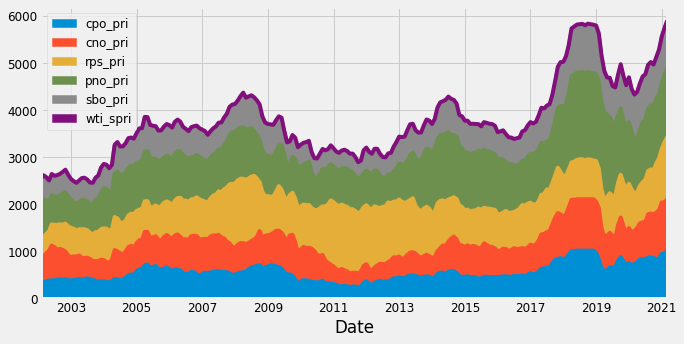

In [27]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('Date');
ax.legend(fontsize=12);

##**CNN-LSTM Forecasting Technique**

###**Split Data into Train Test Segments**

In [28]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 207
Test size: 23


In [29]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

207 23


In [30]:
print(train.shape)
train.head()

(207, 6)


,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,455.0,423.45,844.0,468.0,28.67
2002-03-01,345.0,546.0,415.85,799.0,485.0,24.49
2002-04-01,362.0,595.0,410.77,718.0,466.0,22.06
2002-05-01,376.0,636.0,414.82,614.0,442.0,21.64
2002-06-01,383.0,738.0,451.04,619.0,429.0,22.30


###Rescale train dataset

In [31]:
#f_transformer = RobustScaler()
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'wti_spri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2002-02-01,323.0,0.210429,0.013238,0.218695,0.265091,0.109026
2002-03-01,345.0,0.323070,0.005303,0.183797,0.289974,0.044200
2002-04-01,362.0,0.383723,0.000000,0.120980,0.262164,0.006514
2002-05-01,376.0,0.434473,0.004228,0.040327,0.227035,0.000000
2002-06-01,383.0,0.560730,0.042041,0.044204,0.208007,0.010236


In [32]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

Date
2002-02-01    0.114359
2002-03-01    0.142628
2002-04-01    0.164472
2002-05-01    0.182461
2002-06-01    0.191455
Name: cpo_pri, dtype: float64

In [33]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,rps_pri,pno_pri,sbo_pri,wti_spri
Date,,,,,,
2019-05-01,587.0,0.563206,0.422889,0.930375,0.671342,0.331576
2019-06-01,659.0,0.555779,0.448122,0.820392,0.736243,0.364144
2019-07-01,656.0,0.480272,0.453614,0.760965,0.674401,0.415167
2019-08-01,660.0,0.420857,0.487240,0.754745,0.649621,0.462314
2019-09-01,800.0,0.571871,0.513956,0.675472,0.764331,0.545751


In [34]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

Date
2019-05-01    0.453582
2019-06-01    0.546097
2019-07-01    0.542242
2019-08-01    0.547382
2019-09-01    0.727273
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [35]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 4
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(203, 4, 6) (203,)


###Create Model

####Declare input shape

In [36]:
subsequences = 2
timesteps = X_train.shape[1]//subsequences
X_train_sub = X_train.reshape(X_train.shape[0], subsequences, timesteps, X_train.shape[2])
X_test_sub = X_test.reshape(X_test.shape[0], subsequences, timesteps, X_test.shape[2])
print("X_train_sub shape:", X_train_sub.shape)
print("X_test_sub shape:", X_test_sub.shape)

X_train_sub shape: (203, 2, 2, 6)
X_test_sub shape: (19, 2, 2, 6)


In [37]:
cnn_lstm_model = tf.keras.Sequential()
cnn_lstm_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_sub.shape[2], X_train_sub.shape[3])))
cnn_lstm_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling1D(pool_size=2)))
cnn_lstm_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()))
cnn_lstm_model.add(tf.keras.layers.LSTM(50, activation='relu'))
cnn_lstm_model.add(tf.keras.layers.Dense(1))
cnn_lstm_model.compile(loss='mse', optimizer='adam')
cnn_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 2, 64)      448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                23000     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                        

In [38]:
cnn_lstm_history = cnn_lstm_model.fit(X_train_sub, y_train, validation_data=(X_test_sub, y_test), epochs=50)

Epoch 1/50
7/7 [==============================] - 4s 60ms/step - loss: 0.1098 - val_loss: 0.2787
Epoch 2/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0542 - val_loss: 0.1135
Epoch 3/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0273 - val_loss: 0.0303
Epoch 4/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0221 - val_loss: 0.0211
Epoch 5/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0152 - val_loss: 0.0266
Epoch 6/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0119 - val_loss: 0.0251
Epoch 7/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 8/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0094 - val_loss: 0.0090
Epoch 9/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0093 - val_loss: 0.0116
Epoch 10/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0091 - val_loss: 0.0085
Epoch 11/50
7/7 [====================

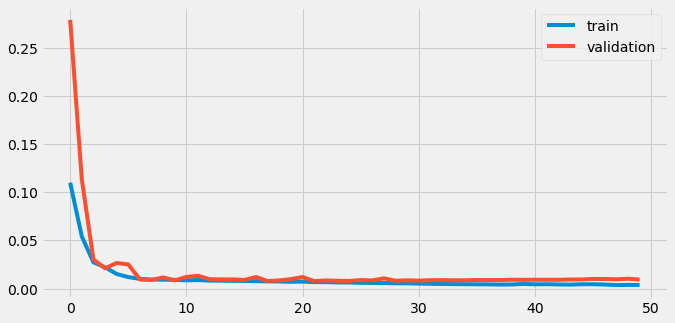

In [39]:
plt.plot(cnn_lstm_history.history['loss'], label='train')
plt.plot(cnn_lstm_history.history['val_loss'], label='validation')
plt.legend()
plt.show()

###Predict the Test Data

In [52]:
y_pred = cnn_lstm_model.predict(X_test_sub)

In [53]:
y_pred

array([[0.49496865],
       [0.57736135],
       [0.6585529 ],
       [0.7224831 ],
       [0.7324585 ],
       [0.73484075],
       [0.72036177],
       [0.71204686],
       [0.7378312 ],
       [0.7655073 ],
       [0.7844021 ],
       [0.7994601 ],
       [0.84666884],
       [0.80053574],
       [0.8170917 ],
       [0.81919354],
       [0.84447855],
       [0.9241355 ],
       [0.9548853 ]], dtype=float32)

In [54]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[ 383.    382.    396.    402.    390.    404.    382.    382.    391.
   396.    413.    401.    410.    425.    408.    392.    371.    356.
   362.    356.    352.    333.    357.    411.    404.    387.    395.
   434.    488.    508.    494.    575.    614.    616.    707.    719.
   655.    661.    687.    625.    611.    631.    655.    616.    586.
   615.    607.    590.    535.    518.    519.    562.    552.    508.
   476.    513.    545.    532.    550.    561.    567.    580.    559.
   562.    553.    533.    498.    504.    525.    547.    556.    566.
   621.    659.    671.    688.    705.    633.    661.    674.    703.
   694.    681.    663.    632.    561.    497.    509.    475.    392.
   319.    354.    388.    381.    370.    354.    348.    332.    349.
   372.    324.    315.    312.    306.    288.    255.    257.    265.
   254.    240.    254.    251.    234.    255.    330.    362.    310.
   277.    323.    360.    374.    353.    359.    360.    385. 

###Invert Transformed Data

In [55]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[ 383.    382.    396.    402.    390.    404.    382.    382.    391.
   396.    413.    401.    410.    425.    408.    392.    371.    356.
   362.    356.    352.    333.    357.    411.    404.    387.    395.
   434.    488.    508.    494.    575.    614.    616.    707.    719.
   655.    661.    687.    625.    611.    631.    655.    616.    586.
   615.    607.    590.    535.    518.    519.    562.    552.    508.
   476.    513.    545.    532.    550.    561.    567.    580.    559.
   562.    553.    533.    498.    504.    525.    547.    556.    566.
   621.    659.    671.    688.    705.    633.    661.    674.    703.
   694.    681.    663.    632.    561.    497.    509.    475.    392.
   319.    354.    388.    381.    370.    354.    348.    332.    349.
   372.    324.    315.    312.    306.    288.    255.    257.    265.
   254.    240.    254.    251.    234.    255.    330.    362.    310.
   277.    323.    360.    374.    353.    359.    360.    385. 

###Plot History, Actual and Predicted Value

In [56]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([ 383.  ,  382.  ,  396.  ,  402.  ,  390.  ,  404.  ,  382.  ,
        382.  ,  391.  ,  396.  ,  413.  ,  401.  ,  410.  ,  425.  ,
        408.  ,  392.  ,  371.  ,  356.  ,  362.  ,  356.  ,  352.  ,
        333.  ,  357.  ,  411.  ,  404.  ,  387.  ,  395.  ,  434.  ,
        488.  ,  508.  ,  494.  ,  575.  ,  614.  ,  616.  ,  707.  ,
        719.  ,  655.  ,  661.  ,  687.  ,  625.  ,  611.  ,  631.  ,
        655.  ,  616.  ,  586.  ,  615.  ,  607.  ,  590.  ,  535.  ,
        518.  ,  519.  ,  562.  ,  552.  ,  508.  ,  476.  ,  513.  ,
        545.  ,  532.  ,  550.  ,  561.  ,  567.  ,  580.  ,  559.  ,
        562.  ,  553.  ,  533.  ,  498.  ,  504.  ,  525.  ,  547.  ,
        556.  ,  566.  ,  621.  ,  659.  ,  671.  ,  688.  ,  705.  ,
        633.  ,  661.  ,  674.  ,  703.  ,  694.  ,  681.  ,  663.  ,
        632.  ,  561.  ,  497.  ,  509.  ,  475.  ,  392.  ,  319.  ,
        354.  ,  388.  ,  381.  ,  370.  ,  354.  ,  348.  ,  332.  ,
        349.  ,  372

In [57]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([ 800.  ,  873.  ,  789.  ,  698.  ,  746.  ,  704.  ,  725.  ,
        763.  ,  822.  ,  831.  ,  830.  ,  863.  ,  863.  ,  855.  ,
        826.  ,  844.  ,  944.  ,  949.  , 1012.25])

In [58]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([619.20935, 683.3315 , 746.5188 , 796.2725 , 804.03577, 805.8898 ,
       794.6216 , 788.15045, 808.21716, 829.75604, 844.46094, 856.1799 ,
       892.92   , 857.01697, 869.9016 , 871.5374 , 891.21545, 953.2085 ,
       977.1395 ], dtype=float32)

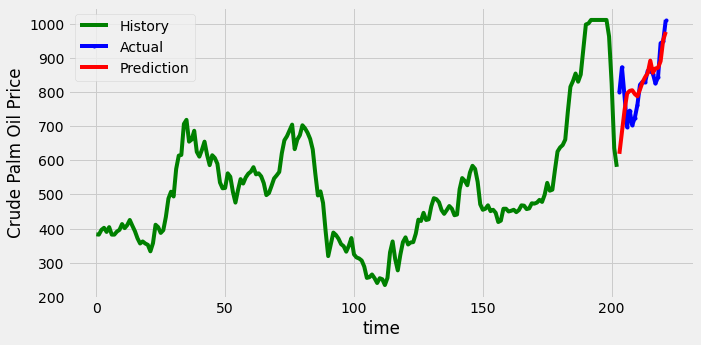

In [59]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('time')
plt.legend()
plt.show();

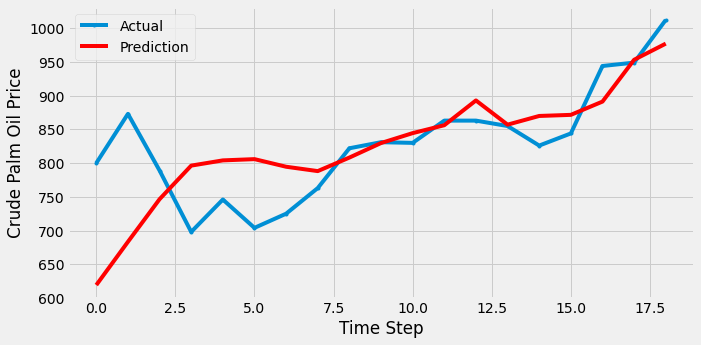

In [60]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Evaluate cnn-lstm Model Accuracy

In [ ]:
...updating